In [1]:
!pip install toolz scikit-allel

import os
import numpy as np
import pandas as pd
import ast
import math
import re
import itertools
import random
import json
import matplotlib
from matplotlib.pyplot import plot as plt
from scipy.spatial.distance import squareform
from pylab import *
mpl.use("pgf")
# activate latex text rendering
rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble':r'\usepackage{sfmath} \boldmath'
})
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import allel
sns.set_theme(style="white")


You should consider upgrading via the 'c:\users\sleepy\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
# load data
root_dir = './data/'
file_name = "ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf"
new_data_header = ""
# get header
with open(root_dir + file_name, 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + file_name,
                        comment='#', sep='\t',
                        names=new_data_header.strip().split('\t'),
                        header=None)
headers = genotypes.columns[9:]
genotypes.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,22,16050654,DUP_gs_CNV_22_16050654_16063474,A,"<CN0>,<CN2>,<CN3>,<CN4>",.,PASS,"AC=9,87,599,20;AF=0.00179712,0.0173722,0.11960...",GT,3|0,...,0|0,0|0,0|0,0|0,0|0,3|0,3|0,0|0,0|0,0|0
1,22,16533236,SI_BD_17525,C,<CN0>,100,PASS,AC=125;AF=0.0249601;AFR_AF=0.09;AMR_AF=0.0086;...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,22,16577743,YL_CN_CEU_5170,T,<CN0>,100,PASS,AC=29;AF=0.00579073;AFR_AF=0.0098;AMR_AF=0.001...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,22,16589908,SI_BD_17528,T,<CN0>,100,PASS,AC=186;AF=0.0371406;AFR_AF=0.1021;AMR_AF=0.014...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,22,16633635,YL_CN_STU_4360,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [3]:
def find_info_chunk(s, info_key="SVTYPE"):
  s_split = s.split(";")
  for ss in s_split:
    if ss.startswith(info_key):
      return ss
  return ""

In [4]:
info = genotypes.iloc[:, 7:8]
snv_types = info.applymap(lambda x: find_info_chunk(x, "SVTYPE").split("=")[-1]).values.flatten()
ACs = info.applymap(lambda x: len([int(m) for m in find_info_chunk(x, "AC").split("=")[-1].split(",")])).values.flatten()
is_biallelic = np.array([ac==1 for ac in ACs])
snv_types.shape, np.unique(snv_types, return_counts=True)

((848,),
 (array(['ALU', 'CNV', 'DEL', 'DEL_ALU', 'DUP', 'INS', 'INV', 'LINE1',
         'SVA'], dtype=object),
  array([ 96,  55, 573,   9,  79,   4,   5,   7,  20], dtype=int64)))

In [5]:
ped_file = 'integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(root_dir+ped_file, sep='\t', index_col='Individual ID')
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [6]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

genotype_keys = np.unique(genotypes.iloc[:, 9:].T.values)
max_gen = max(map(get_max_genotype, genotype_keys))
onehot_encoding_depth = max_gen**2 + 1
genotype_keys = [key_gen(i,j) for i in range(max_gen) for j in range(max_gen)]
replacement_dict = {k:i for i,k in enumerate(genotype_keys)}
reverse_replacement_dict = {v:k for k,v in replacement_dict.items()}
max_gen, onehot_encoding_depth

(6, 37)

In [7]:
Y_train = pedigree.loc[genotypes.iloc[:, 9:].T.index]['Population']
X = genotypes.iloc[:, 9:].T[genotypes.iloc[:, 9:].T.index.isin(Y_train.index)]
X = X.replace(replacement_dict)
X.shape

(2504, 848)

In [8]:
callset = allel.read_vcf(root_dir + 'ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf')
g = allel.GenotypeArray(callset['calldata/GT'][callset['variants/CHROM'] == '22'])
gn = g.to_n_alt(fill=-1)
r = allel.rogers_huff_r(gn)
LD = squareform(r ** 2)
LD.shape

(848, 848)

<AxesSubplot:>

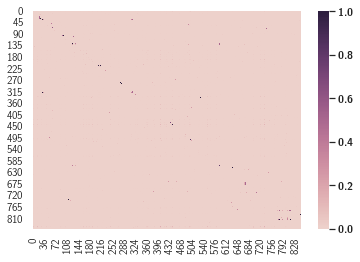

In [82]:
# plt.figure(figsize=(8,8))
sns.heatmap(LD, cmap=sns.cubehelix_palette(as_cmap=True))
# plt.show()

(array([553.,  97.,  81.,  19.,  98.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

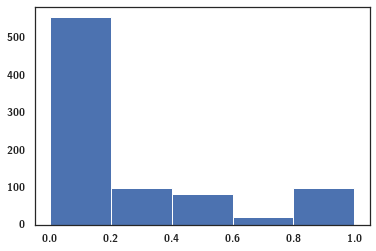

In [9]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.max(LD, axis=1), bins=bins)

In [10]:
LD_max_freqs = np.amax(LD, axis=1)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5], dtype=int64),
 array([553,  97,  81,  19,  98], dtype=int64))

In [11]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type", "Is Biallelic"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/HLA_DEEP/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = snv_types[missing_index].reshape((-1, 1))
        g = is_biallelic[missing_index].reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f,g], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 528.63it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 331.88it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 188.60it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 559.03it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 332.25it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 189.36it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 548.72it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 344.66it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 187.45it/s]


Combining the results...


9it [00:00, 60.93it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type,Is Biallelic
0,1,0.05,0 <= LD < 0.2,1,NA21144,DUP,True
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL,True
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
4,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
...,...,...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097,DEL,True
738676,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738677,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL,True


In [86]:
df.to_csv("results_in_table/Chr22/ALL/LD_HLA_DEEP.csv")

In [87]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.937700  0.241702
            0.2 <= LD < 0.4  0.973642  0.160203
            0.4 <= LD < 0.6  0.998303  0.041165
            0.6 <= LD < 0.8  0.994808  0.071880
            0.8 <= LD <= 1   0.986422  0.115737
0.10        0 <= LD < 0.2    0.938419  0.240395
            0.2 <= LD < 0.4  0.973110  0.161766
            0.4 <= LD < 0.6  0.998053  0.044082
            0.6 <= LD < 0.8  0.994609  0.073235
            0.8 <= LD <= 1   0.986222  0.116570
0.20        0 <= LD < 0.2    0.938331  0.240553
            0.2 <= LD < 0.4  0.972087  0.164726
            0.4 <= LD < 0.6  0.997804  0.046816
            0.6 <= LD < 0.8  0.993011  0.083311
            0.8 <= LD <= 1   0.986562  0.115144

In [88]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.953094
     0.10         0.953921
     0.20         0.953747
2    0.05         0.956573
     0.10         0.955845
     0.20         0.955271
3    0.05         0.955065
     0.10         0.954765
     0.20         0.955259

In [89]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.954910  0.001744
0.10         0.954844  0.000965
0.20         0.954759  0.000876

In [12]:
# df1 = df.groupby(["Fold", "SNV type", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
# df1 = df1.groupby(["Fold", "MissingRate", "SNV type"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
# df1 = df1.groupby(["SNV type"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
# df_to_write = df1.loc[:, ["Fold", "MissingRate", "SNV type","Accuracy", "Sample ID"]]
df_to_write = df.copy()
df_to_write["Method"] = "HLA*DEEP"
df_to_write.to_csv("experimental_results/Chr22/ALL/detailed_results.csv",
                   index=False, header=True, mode='w')
df.loc[:, ["Fold", "MissingRate", "SNV type","Accuracy", "Sample ID"]]

,Fold,MissingRate,SNV type,Accuracy,Sample ID
0,1,0.05,DUP,1,NA21144
1,1,0.05,DEL,1,NA21144
2,1,0.05,DEL,1,NA21144
3,1,0.05,DEL,1,NA21144
4,1,0.05,DEL,1,NA21144
...,...,...,...,...,...
738675,3,0.2,DEL,1,HG00097
738676,3,0.2,DEL,1,HG00097
738677,3,0.2,DEL,1,HG00097
738678,3,0.2,DEL,1,HG00097


In [13]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type", "Is Biallelic"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/SCDA/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = snv_types[missing_index].reshape((-1, 1))
        g = is_biallelic[missing_index].reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f,g], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 530.45it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 341.10it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 189.82it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 550.70it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 340.75it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 182.37it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 529.44it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 332.29it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 187.15it/s]


Combining the results...


9it [00:00, 56.08it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type,Is Biallelic
0,1,0.05,0 <= LD < 0.2,1,NA21144,DUP,True
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL,True
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
4,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
...,...,...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097,DEL,True
738676,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738677,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL,True


In [14]:
# df.to_csv("results_in_table/Chr22/ALL/LD_SCDA.csv")

In [15]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.936265  0.244282
            0.2 <= LD < 0.4  0.970367  0.169578
            0.4 <= LD < 0.6  0.997704  0.047867
            0.6 <= LD < 0.8  0.994010  0.077181
            0.8 <= LD <= 1   0.986661  0.114725
0.10        0 <= LD < 0.2    0.937838  0.241451
            0.2 <= LD < 0.4  0.969382  0.172283
            0.4 <= LD < 0.6  0.997354  0.051370
            0.6 <= LD < 0.8  0.993810  0.078441
            0.8 <= LD <= 1   0.985743  0.118552
0.20        0 <= LD < 0.2    0.938484  0.240275
            0.2 <= LD < 0.4  0.968261  0.175305
            0.4 <= LD < 0.6  0.997180  0.053034
            0.6 <= LD < 0.8  0.992312  0.087346
            0.8 <= LD <= 1   0.985703  0.118714

In [16]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.952837
     0.10         0.953650
     0.20         0.953818
2    0.05         0.954919
     0.10         0.954691
     0.20         0.954569
3    0.05         0.952895
     0.10         0.953423
     0.20         0.954366

In [17]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.953550  0.001185
0.10         0.953921  0.000676
0.20         0.954251  0.000389

In [18]:
# df1 = df.groupby(["Fold", "SNV type", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
# df1 = df1.groupby(["Fold", "MissingRate", "SNV type"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
# df1 = df1.groupby(["SNV type"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
# df_to_write = df1.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]
df_to_write = df.copy()
df_to_write["Method"] = "SCDA+"
df_to_write.to_csv("experimental_results/Chr22/ALL/detailed_results.csv",
                   index=False, header=False, mode='a')
df.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]

,MissingRate,SNV type,Accuracy,Sample ID
0,0.05,DUP,1,NA21144
1,0.05,DEL,1,NA21144
2,0.05,DEL,1,NA21144
3,0.05,DEL,1,NA21144
4,0.05,DEL,1,NA21144
...,...,...,...,...
738675,0.2,DEL,1,HG00097
738676,0.2,DEL,1,HG00097
738677,0.2,DEL,1,HG00097
738678,0.2,DEL,1,HG00097


In [19]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type", "Is Biallelic"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/AE/preds_mixed_mr_{missing_perc}_fold_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    # result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = snv_types[missing_index].reshape((-1, 1))
        g = is_biallelic[missing_index].reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f,g], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 528.51it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:03<00:00, 262.22it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 167.00it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 532.71it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 346.71it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 188.50it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 550.07it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 347.13it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 187.99it/s]


Combining the results...


9it [00:00, 61.50it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type,Is Biallelic
0,1,0.05,0 <= LD < 0.2,1,NA21144,DUP,True
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL,True
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
4,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
...,...,...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097,DEL,True
738676,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738677,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL,True


In [20]:
# df.to_csv("results_in_table/Chr22/ALL/LD_AE.csv")

In [21]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.933795  0.248642
            0.2 <= LD < 0.4  0.965655  0.182121
            0.4 <= LD < 0.6  0.996905  0.055550
            0.6 <= LD < 0.8  0.994409  0.074579
            0.8 <= LD <= 1   0.987859  0.109518
0.10        0 <= LD < 0.2    0.935870  0.244985
            0.2 <= LD < 0.4  0.963037  0.188675
            0.4 <= LD < 0.6  0.997304  0.051851
            0.6 <= LD < 0.8  0.993411  0.080916
            0.8 <= LD <= 1   0.980112  0.139619
0.20        0 <= LD < 0.2    0.937006  0.242952
            0.2 <= LD < 0.4  0.964940  0.183933
            0.4 <= LD < 0.6  0.996905  0.055548
            0.6 <= LD < 0.8  0.992612  0.085641
            0.8 <= LD <= 1   0.986482  0.115481

In [22]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.950271
     0.10         0.950941
     0.20         0.953180
2    0.05         0.953065
     0.10         0.950299
     0.20         0.953109
3    0.05         0.951096
     0.10         0.952567
     0.20         0.952677

In [23]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.951477  0.001436
0.10         0.951269  0.001169
0.20         0.952989  0.000272

In [24]:
df_to_write = df.copy()
df_to_write["Method"] = "AE+"
df_to_write.to_csv("experimental_results/Chr22/ALL/detailed_results.csv",
                   index=False, header=False, mode='a')
df.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]

,MissingRate,SNV type,Accuracy,Sample ID
0,0.05,DUP,1,NA21144
1,0.05,DEL,1,NA21144
2,0.05,DEL,1,NA21144
3,0.05,DEL,1,NA21144
4,0.05,DEL,1,NA21144
...,...,...,...,...
738675,0.2,DEL,1,HG00097
738676,0.2,DEL,1,HG00097
738677,0.2,DEL,1,HG00097
738678,0.2,DEL,1,HG00097


In [25]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type", "Is Biallelic"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/STI_WE/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = snv_types[missing_index].reshape((-1, 1))
        g = is_biallelic[missing_index].reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f,g], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df


Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 452.04it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 280.10it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 177.04it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 561.90it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 345.78it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 193.50it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 559.12it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 350.66it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 188.73it/s]


Combining the results...


9it [00:00, 62.09it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type,Is Biallelic
0,1,0.05,0 <= LD < 0.2,1,NA21144,DUP,True
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL,True
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
4,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
...,...,...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097,DEL,True
738676,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738677,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL,True


In [26]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.937818  0.241488
            0.2 <= LD < 0.4  0.972923  0.162313
            0.4 <= LD < 0.6  0.997604  0.048894
            0.6 <= LD < 0.8  0.994409  0.074579
            0.8 <= LD <= 1   0.988578  0.106265
0.10        0 <= LD < 0.2    0.938912  0.239492
            0.2 <= LD < 0.4  0.972710  0.162930
            0.4 <= LD < 0.6  0.997504  0.049899
            0.6 <= LD < 0.8  0.994209  0.075884
            0.8 <= LD <= 1   0.988578  0.106263
0.20        0 <= LD < 0.2    0.939148  0.239059
            0.2 <= LD < 0.4  0.971814  0.165507
            0.4 <= LD < 0.6  0.997454  0.050394
            0.6 <= LD < 0.8  0.992412  0.086782
            0.8 <= LD <= 1   0.987600  0.110665

In [27]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.954063
     0.10         0.955033
     0.20         0.954959
2    0.05         0.956259
     0.10         0.955703
     0.20         0.955341
3    0.05         0.954922
     0.10         0.955293
     0.20         0.955706

In [28]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.955081  0.001106
0.10         0.955343  0.000338
0.20         0.955336  0.000374

In [29]:
# df1 = df.groupby(["Fold", "SNV type", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
# df1 = df1.groupby(["Fold", "MissingRate", "SNV type"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
# df1 = df1.groupby(["SNV type"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
# df_to_write = df1.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]
df_to_write = df.copy()
df_to_write["Method"] = "STI*WE"
df_to_write.to_csv("experimental_results/Chr22/ALL/detailed_results.csv",
                   index=False, header=False, mode='a')
df.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]



,MissingRate,SNV type,Accuracy,Sample ID
0,0.05,DUP,1,NA21144
1,0.05,DEL,1,NA21144
2,0.05,DEL,1,NA21144
3,0.05,DEL,1,NA21144
4,0.05,DEL,1,NA21144
...,...,...,...,...
738675,0.2,DEL,1,HG00097
738676,0.2,DEL,1,HG00097
738677,0.2,DEL,1,HG00097
738678,0.2,DEL,1,HG00097


In [30]:

columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type", "Is Biallelic"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/STI/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = snv_types[missing_index].reshape((-1, 1))
        g = is_biallelic[missing_index].reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f,g], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 476.28it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 288.41it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 185.63it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 558.60it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 346.46it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:04<00:00, 193.91it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 501.09it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 335.02it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 188.89it/s]


Combining the results...


9it [00:00, 55.19it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type,Is Biallelic
0,1,0.05,0 <= LD < 0.2,1,NA21144,DUP,True
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL,True
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
4,1,0.05,0 <= LD < 0.2,1,NA21144,DEL,True
...,...,...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097,DEL,True
738676,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738677,3,0.2,0 <= LD < 0.2,1,HG00097,DEL,True
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL,True


In [31]:
# df.to_csv("results_in_table/Chr22/ALL/LD_STI.csv")

In [32]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})


Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.937774  0.241568
            0.2 <= LD < 0.4  0.974042  0.159018
            0.4 <= LD < 0.6  0.997404  0.050886
            0.6 <= LD < 0.8  0.994010  0.077181
            0.8 <= LD <= 1   0.990815  0.095403
0.10        0 <= LD < 0.2    0.939239  0.238892
            0.2 <= LD < 0.4  0.974175  0.158618
            0.4 <= LD < 0.6  0.997454  0.050394
            0.6 <= LD < 0.8  0.994209  0.075884
            0.8 <= LD <= 1   0.991294  0.092901
0.20        0 <= LD < 0.2    0.939686  0.238069
            0.2 <= LD < 0.4  0.972717  0.162908
            0.4 <= LD < 0.6  0.997479  0.050147
            0.6 <= LD < 0.8  0.993011  0.083311
            0.8 <= LD <= 1   0.990435  0.097331

In [33]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.953179
     0.10         0.954363
     0.20         0.954597
2    0.05         0.957228
     0.10         0.957200
     0.20         0.956858
3    0.05         0.955864
     0.10         0.956535
     0.20         0.956962

In [34]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1


Accuracy          
                 mean       std
MissingRate                    
0.05         0.955424  0.002060
0.10         0.956032  0.001484
0.20         0.956139  0.001336

In [35]:
# df1 = df.groupby(["Fold", "SNV type", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
# df1 = df1.groupby(["Fold", "MissingRate", "SNV type"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
# df1 = df1.groupby(["SNV type"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
# df_to_write = df1.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]
df_to_write = df.copy()
df_to_write["Method"] = "STI"
df_to_write.to_csv("experimental_results/Chr22/ALL/detailed_results.csv",
                   index=False, header=False, mode='a')
df.loc[:, ["MissingRate", "SNV type","Accuracy", "Sample ID"]]

,MissingRate,SNV type,Accuracy,Sample ID
0,0.05,DUP,1,NA21144
1,0.05,DEL,1,NA21144
2,0.05,DEL,1,NA21144
3,0.05,DEL,1,NA21144
4,0.05,DEL,1,NA21144
...,...,...,...,...
738675,0.2,DEL,1,HG00097
738676,0.2,DEL,1,HG00097
738677,0.2,DEL,1,HG00097
738678,0.2,DEL,1,HG00097
